## 01 Import

In [ ]:
# import libraries
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import random
from PIL import Image, ImageDraw

import torch
import torchvision.models as models
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

# 디바이스 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## 02 Download Dataset

Citation: Kritik Seth, "Fruits and Vegetables Image Recognition Dataset," Kaggle 2020 [https://www.kaggle.com/kritikseth/fruit-and-vegetable-image-recognition]

In [ ]:
# # 구글 코랩에서 데이터셋 다운로드 및 준비
# from google.colab import files
# files.upload()  # 'kaggle.json' 파일 업로드

# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# # Orange Diseases 데이터셋 다운로드
# !kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition

# # 압축 해제
# !unzip fruit-and-vegetable-image-recognition.zip -d your_path/fruit-and-vegetable-image

## 03 Load Dataset

In [ ]:
# 데이터 경로 설정
data_dir = 'your_path/fruit-and-vegetable-image'

# 데이터 불러오기
train_dir = os.path.join(data_dir, 'train')
train_filepaths = list(Path(train_dir).rglob('*.jpg')) + \
                  list(Path(train_dir).rglob('*.jpeg')) + \
                  list(Path(train_dir).rglob('*.png')) + \
                  list(Path(train_dir).rglob('*.JPG'))

test_dir = os.path.join(data_dir, 'test')
test_filepaths = list(Path(test_dir).rglob('*.jpg')) + \
                 list(Path(test_dir).rglob('*.jpeg')) + \
                 list(Path(test_dir).rglob('*.png')) + \
                 list(Path(test_dir).rglob('*.JPG'))

val_dir = os.path.join(data_dir, 'validation')
val_filepaths = list(Path(val_dir).rglob('*.jpg')) + \
                 list(Path(val_dir).rglob('*.jpeg')) + \
                 list(Path(val_dir).rglob('*.png')) + \
                 list(Path(val_dir).rglob('*.JPG'))


def proc_img(filepath):
    """
    이미지 파일의 경로와 라벨을 포함하는 DataFrame을 생성하는 함수
    """

    # 파일 경로에서 라벨(폴더명) 추출
    labels = [str(filepath[i]).split("/")[-2] for i in range(len(filepath))]

    # 파일 경로를 pandas Series로 변환하고 문자열로 저장
    filepath = pd.Series(filepath, name='Filepath').astype(str)

    # 라벨을 pandas Series로 변환
    labels = pd.Series(labels, name='Label')

    # 파일 경로와 라벨을 하나의 DataFrame으로 합치기
    df = pd.concat([filepath, labels], axis=1)

    # 데이터 프레임을 랜덤하게 섞고 인덱스 초기화
    df = df.sample(frac=1).reset_index(drop=True)

    return df

# 학습(train), 테스트(test), 검증(validation) 데이터 프레임 생성
train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

# 데이터 확인
train_df.head()

,Filepath,Label
0,/content/drive/MyDrive/Colab_Notebooks/fruit-a...,banana
1,/content/drive/MyDrive/Colab_Notebooks/fruit-a...,garlic
2,/content/drive/MyDrive/Colab_Notebooks/fruit-a...,onion
3,/content/drive/MyDrive/Colab_Notebooks/fruit-a...,pomegranate
4,/content/drive/MyDrive/Colab_Notebooks/fruit-a...,eggplant


## 04 Count Class

In [ ]:
# 클래스 목록 가져오기
class_labels = train_df.Label.unique()

# 데이터 확인
print(f"학습 데이터 개수: {len(train_df)}")
print(f"검증 데이터 개수: {len(test_df)}")
print(f"평가 데이터 개수: {len(val_df)}\n")

# 전체 클래스 개수 출력
print(f"전체 클래스 개수: {len(class_labels)}\n")

# 든 클래스 출력
print(f'클래스 목록: {class_labels}\n')

학습 데이터 개수: 3115
검증 데이터 개수: 359
평가 데이터 개수: 351

전체 클래스 개수: 36

클래스 목록: ['banana' 'garlic' 'onion' 'pomegranate' 'eggplant' 'watermelon'
 'jalepeno' 'raddish' 'peas' 'beetroot' 'spinach' 'soy beans' 'lettuce'
 'corn' 'cauliflower' 'carrot' 'cabbage' 'potato' 'ginger' 'pear' 'kiwi'
 'turnip' 'sweetcorn' 'lemon' 'paprika' 'pineapple' 'chilli pepper'
 'bell pepper' 'grapes' 'tomato' 'sweetpotato' 'apple' 'capsicum'
 'cucumber' 'orange' 'mango']



## 05 Class Balance

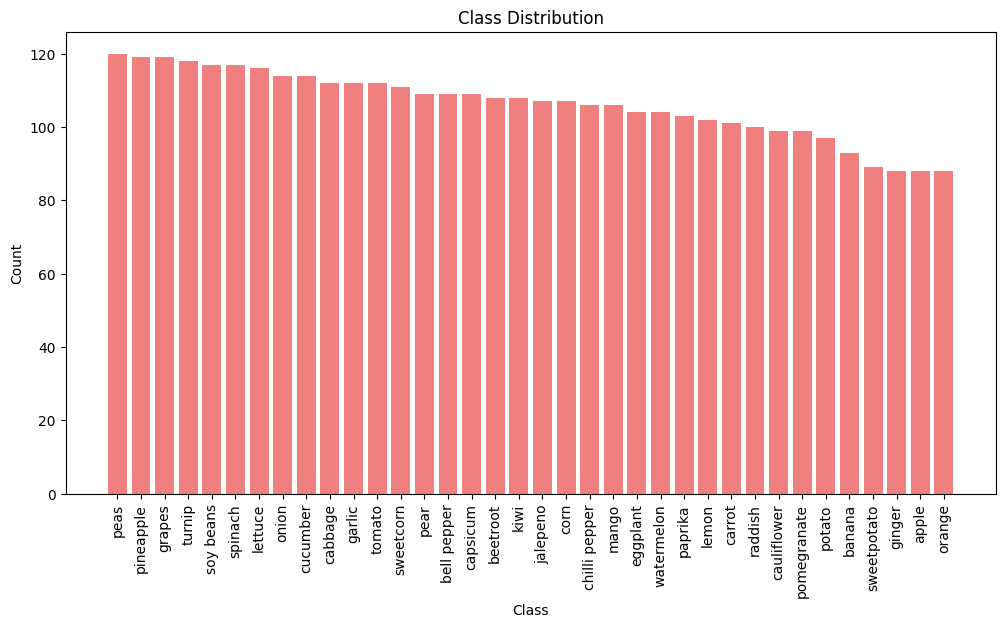

In [ ]:
# 전체 데이터 합치기
df_all = pd.concat([train_df, test_df, val_df], axis=0)

# 클래스별 샘플 개수 계산
class_counts = df_all['Label'].value_counts()

# 클래스별 비율 계산
total_samples = class_counts.sum()
class_ratios = (class_counts / total_samples) * 100

# 히스토그램 (바 그래프)
plt.figure(figsize=(12, 6))
plt.bar(class_counts.index, class_counts.values, color='lightcoral')
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.xticks(rotation=90)
plt.show()

In [ ]:
df_ratio = pd.DataFrame({'Class': class_counts.index, 'Count': class_counts.values, 'Ratio (%)': class_ratios.values})

# 가장 높은 비율 5개 및 낮은 비율 5개 선택
df_top5 = df_ratio.nlargest(5, 'Ratio (%)')
df_bottom5 = df_ratio.nsmallest(5, 'Ratio (%)')

# 데이터프레임 합치기
df_filtered = pd.concat([df_top5, df_bottom5])
df_filtered

,Class,Count,Ratio (%)
0,peas,120,3.137255
1,pineapple,119,3.111111
2,grapes,119,3.111111
3,turnip,118,3.084967
4,soy beans,117,3.058824
33,ginger,88,2.300654
34,apple,88,2.300654
35,orange,88,2.300654
32,sweetpotato,89,2.326797
31,banana,93,2.431373


## 06 Image

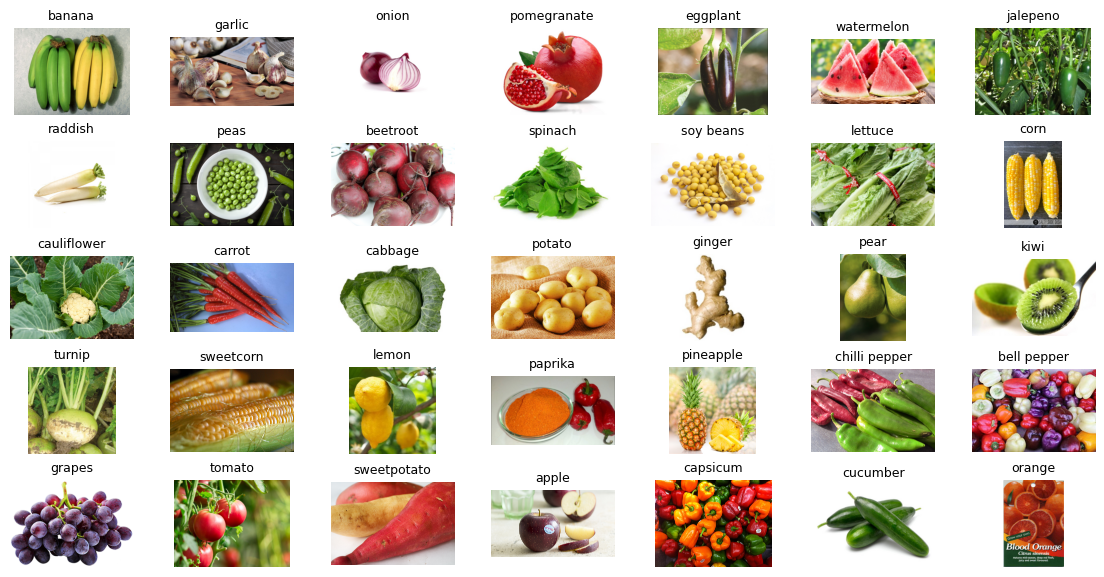

In [ ]:
# 각 카테고리(Label)별로 하나씩만 포함하는 데이터프레임 생성
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# 브플롯 생성
fig, axes = plt.subplots(nrows=5, ncols=7, figsize=(14, 7),
                         subplot_kw={'xticks': [], 'yticks': []})  # x, y축 눈금 제거

# 각 subplot에 이미지 추가
for i, ax in enumerate(axes.flat):
    if i < len(df_unique):  # 데이터 개수보다 subplot이 많을 경우 오류 방지
        ax.imshow(plt.imread(df_unique.Filepath[i]))  # 이미지 불러오기
        ax.set_title(df_unique.Label[i], fontsize=9)  # 라벨 제목 표시

    # 검은색 실선(테두리) 제거
    for spine in ax.spines.values():
        spine.set_visible(False)

# 서브플롯 간 간격 조정
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# 최종 출력
plt.show()

## 05 Create transformer and Augmentation

In [ ]:
# ConvNeXt 모델의 기본 사전 학습된 가중치 불러오기
ConvNeXt_weights = models.ConvNeXt_Base_Weights.DEFAULT

# 해당 가중치에 맞는 변환(transform) 객체 가져오기
ConvNeXt_transformer = ConvNeXt_weights.transforms()

# 변환 객체 출력 (어떤 변환이 적용되는지 확인)
ConvNeXt_transformer

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
# 랜덤한 사각형 노이즈 추가 함수
def add_rectangle_noise(image):
    """이미지에 랜덤한 크기와 위치의 사각형 노이즈 추가"""
    draw = ImageDraw.Draw(image)
    width, height = image.size

    # 노이즈 크기 (전체 이미지 크기의 30~50%)
    box_width = random.randint(int(0.3 * width), int(0.5 * width))
    box_height = random.randint(int(0.3 * height), int(0.5 * height))

    # 랜덤 위치
    x1 = random.randint(0, width - box_width)
    y1 = random.randint(0, height - box_height)
    x2 = x1 + box_width
    y2 = y1 + box_height

    # 랜덤 색상 (0~255 범위)
    noise_color = tuple(np.random.randint(0, 256, size=3).tolist())

    # 사각형 그리기
    draw.rectangle([x1, y1, x2, y2], fill=noise_color)
    return image

# 데이터셋 증강 및 변환 적용
augmented_transform = transforms.Compose([
    transforms.RandomRotation(20),  # -20도 ~ 20도 회전
    transforms.RandomHorizontalFlip(),  # 50% 확률로 좌우 반전
    transforms.Lambda(lambda img: add_rectangle_noise(img)),  # 랜덤한 사각형 노이즈 추가
    ConvNeXt_transformer  # 기본 변환 적용
])

In [ ]:
# 원본과 증강 데이터셋을 각각 생성
train_data_original = ImageFolder(root=train_dir, transform=ConvNeXt_transformer)  # 원본 데이터
train_data_augmented = ImageFolder(root=train_dir, transform=augmented_transform)  # 증강 데이터

validation_data_original = ImageFolder(root=val_dir, transform=ConvNeXt_transformer)  # 검증 원본 데이터
validation_data_augmented = ImageFolder(root=val_dir, transform=augmented_transform)  # 검증 증강 데이터

In [ ]:
### 시각화용
# 배치 크기 및 워커(worker) 수 설정
BATCH_SIZE = 64
NUM_WORKERS = os.cpu_count()

# 원본 및 증강 데이터 로더 개별 생성
train_original_dataloader = DataLoader(dataset=train_data_original,
                                       batch_size=BATCH_SIZE,
                                       num_workers=NUM_WORKERS,
                                       shuffle=False,
                                       pin_memory=True)

train_augmented_dataloader = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        num_workers=NUM_WORKERS,
                                        shuffle=False,
                                        pin_memory=True)

# 클래스 이름 가져오기
class_labels = train_data_original.classes

# 배치에서 샘플 하나 가져오기 (원본과 증강)
original_images, original_labels = next(iter(train_original_dataloader))
augmented_images, augmented_labels = next(iter(train_augmented_dataloader))

In [ ]:
# 시각화할 이미지 인덱스 (i번째 이미지)
i = 10  # 원하는 샘플 번호 선택 가능

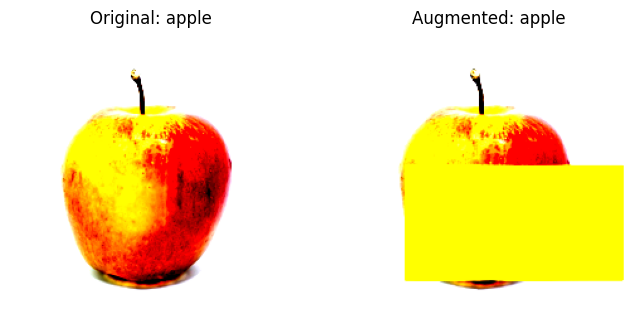

In [ ]:
# 서브플롯 생성 (원본과 증강 나란히 표시)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# 원본 이미지 출력 (왼쪽)
axes[0].imshow(original_images[i].permute(1, 2, 0))  # (C, H, W) → (H, W, C)
axes[0].set_title(f"Original: {class_labels[original_labels[i].item()]}")
axes[0].axis(False)

# 증강된 이미지 출력 (오른쪽)
axes[1].imshow(augmented_images[i].permute(1, 2, 0))  # (C, H, W) → (H, W, C)
axes[1].set_title(f"Augmented: {class_labels[augmented_labels[i].item()]}")
axes[1].axis(False)

# 최종 출력
plt.show();

## Final Data

In [ ]:
# 본격적으로 결합
train_data_transformed = torch.utils.data.ConcatDataset([train_data_original, train_data_augmented])
validation_data_transformed = torch.utils.data.ConcatDataset([validation_data_original, validation_data_augmented])

print(f"Original dataset size: {len(train_data_original)}")
print(f"Augmented dataset size: {len(train_data_augmented)}")
print(f"Combined dataset size: {len(train_data_transformed)}\n")
print(f"Validation dataset szie: {len(validation_data_transformed)}")

# 테스트 데이터는 원본 그대로 유지
test_data_transformed = ImageFolder(root=test_dir, transform=ConvNeXt_transformer)

# 변환된 데이터셋 확인
print(train_data_original, '\n\n', train_data_augmented)

Original dataset size: 3115
Augmented dataset size: 3115
Combined dataset size: 6230

Validation dataset szie: 702
Dataset ImageFolder
    Number of datapoints: 3115
    Root location: /content/drive/MyDrive/Colab_Notebooks/fruit-and-vegetable-image/train
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[232]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           ) 

 Dataset ImageFolder
    Number of datapoints: 3115
    Root location: /content/drive/MyDrive/Colab_Notebooks/fruit-and-vegetable-image/train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               Lambda()
               ImageClassification(
               crop_size=[224]
               resize_size=[232]
               mean=[0.